In [13]:
import plotly.express as px # might not need this.
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

from sklearn.cluster import AgglomerativeClustering

In [52]:
df = pd.read_csv(
    '../data/cleaned/final_combined.csv',
    dtype = {'fips':object}
)
df

,fips,total_pop_age_sex,median_age,sex_ratio_males,under_18_percent,over_18_percent,over_65_percent,county,state,total_hh,median_hh_income,mean_hh_income,total_families,median_family_income,mean_family_income,tot_pop_race_ethnicity,tot_white,tot_black_af_am,tot_aminalnat,tot_asian,tot_hawopi,total_pop_poverty,pop_below_poverty,percent_below_poverty,smoking_ban_2010,asian_2019,avg_family_size_2019,black_2019,hispanic_2019,household_has_broadband_2019,household_has_computer_2019,household_has_smartphone_2019,households_2019,households_speak_limited_english_2019,housing_mobile_homes_2019,hs_grad_2019,median_household_income_2019,median_individual_income_2019,native_2019,other_single_race_2019,pac_isl_2019,persons_per_household_2019,pop_2019,unemployment_rate_2019,uninsured_2019,veterans_2019,white_2019,white_not_hispanic_2019,rural_urban_continuum_code_2013,Metro2013,retirement_destination_2015_update,metro_adjacent_2013,average_2011_upper_bound_pct_obesity,FIPS,obesity_prev_100K
0,01001,55380.0,38.2,94.7,23.8,76.2,15.0,Autauga County,Alabama,21397.0,58731.0,75326.0,15076.0,71103.0,87094.0,55380.0,42527.0,10538.0,140.0,573.0,26.0,54922.0,8340.0,15.2,none,1.0,3.09,19.0,2.8,80.6,73.0,78.4,21397.0,0.7,26.7,88.5,58731.0,29725.0,0.3,0.7,0.0,2.56,55380.0,3.5,7.1,12.6,76.8,74.6,2.0,1.0,1.0,0.0,42.970,1001,71.952925
1,01003,212830.0,43.0,94.7,21.7,78.3,20.0,Baldwin County,Alabama,80930.0,58320.0,80986.0,53467.0,75850.0,97991.0,212830.0,183471.0,19718.0,1645.0,1969.0,9.0,209618.0,21704.0,10.4,none,0.9,3.24,9.3,4.6,81.8,76.3,81.7,80930.0,1.2,24.8,90.8,58320.0,29802.0,0.8,1.1,0.0,2.59,212830.0,4.0,8.9,11.8,86.2,83.1,3.0,1.0,1.0,0.0,37.685,1003,58.781387
2,01005,25361.0,40.4,112.4,20.9,79.1,18.6,Barbour County,Alabama,9345.0,32525.0,47068.0,6187.0,41704.0,56374.0,25361.0,11869.0,12066.0,82.0,134.0,1.0,22417.0,6875.0,30.7,partial,0.5,3.01,47.6,4.4,60.5,51.9,64.2,9345.0,1.6,39.1,73.2,32525.0,17963.0,0.3,3.6,0.0,2.41,25361.0,9.4,11.3,6.6,46.8,45.8,6.0,0.0,0.0,1.0,51.675,1005,63.554734
3,01007,22493.0,40.9,117.5,20.6,79.4,15.9,Bibb County,Alabama,6891.0,47542.0,60182.0,4789.0,57891.0,69316.0,22493.0,17272.0,5014.0,30.0,27.0,0.0,20632.0,3740.0,18.1,none,0.1,3.74,22.3,2.6,69.2,54.7,66.6,6891.0,0.6,25.6,79.1,47542.0,21958.0,0.1,0.0,0.0,2.99,22493.0,7.0,10.7,8.0,76.8,74.5,1.0,1.0,0.0,0.0,47.940,1007,79.901207
4,01009,57681.0,40.7,97.6,23.2,76.8,17.9,Blount County,Alabama,20847.0,49358.0,65639.0,14874.0,62295.0,76547.0,57681.0,55062.0,928.0,46.0,212.0,25.0,57108.0,7739.0,13.6,none,0.4,3.33,1.6,9.3,73.0,63.5,70.1,20847.0,1.8,21.2,80.5,49358.0,26976.0,0.1,0.9,0.0,2.74,57681.0,3.1,10.8,7.7,95.5,86.9,1.0,1.0,0.0,0.0,45.425,1009,65.344687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127,56037,43521.0,35.3,106.8,26.5,73.5,11.4,Sweetwater County,Wyoming,15523.0,74843.0,85346.0,10794.0,87906.0,97459.0,43521.0,40642.0,502.0,508.0,340.0,19.0,42958.0,4921.0,11.5,none,0.8,3.32,1.2,15.9,84.0,81.9,83.4,15523.0,1.9,23.8,92.8,74843.0,36512.0,1.2,1.2,0.0,2.77,43521.0,5.7,11.3,8.6,93.4,79.6,5.0,0.0,0.0,0.0,39.170,56037,57.186138
3128,56039,23280.0,39.3,112.5,19.1,80.9,14.0,Teton County,Wyoming,9019.0,84678.0,132531.0,5190.0,110667.0,172024.0,23280.0,20785.0,290.0,77.0,291.0,29.0,23188.0,1426.0,6.1,partial,1.3,3.01,1.2,15.0,87.1,90.1,85.3,9019.0,5.7,39.6,95.2,84678.0,40914.0,0.3,7.1,0.1,2.47,23280.0,0.7,12.7,5.3,89.3,81.3,7.0,0.0,0.0,0.0,23.825,56039,41.840714
3129,56041,20479.0,35.8,103.3,29.2,70.8,13.0,Uinta County,Wyoming,7597.0,63403.0,74938.0,5313.0,77725.0,86265.0,20479.0,19132.0,23.0,145.0,32.0,0.0,20259.0,2298.0,11.3,none,0.2,3.23,0.1,9.1,89.5,80.3,84.8,7597.0,0.6,22.9,92.7,63403.0,29557.0,0.7,2.1,0.0,2.66,20479.0,5.5,11.2,7.4,93.4,87.5,7.0,0.0,0.0,0.0,39.580,56041,53.049534
3130,56043,8027.0,42.9,102.6,24.6,75.4,21.1,Washakie County,Wyoming,3365.0,54158.0,65496.0,2191.0,68265.0,77355

In [53]:
# Smoking ban is the only variable that has null values. We'll check what the prevalent one is and fillna().
df.isna().sum()

fips                                      0
total_pop_age_sex                         0
median_age                                0
sex_ratio_males                           0
under_18_percent                          0
over_18_percent                           0
over_65_percent                           0
county                                    0
state                                     0
total_hh                                  0
median_hh_income                          0
mean_hh_income                            0
total_families                            0
median_family_income                      0
mean_family_income                        0
tot_pop_race_ethnicity                    0
tot_white                                 0
tot_black_af_am                           0
tot_aminalnat                             0
tot_asian                                 0
tot_hawopi                                0
total_pop_poverty                         0
pop_below_poverty               

In [54]:
df['smoking_ban_2010'].value_counts(normalize=True)

none             0.618480
partial          0.203799
comprehensive    0.177721
Name: smoking_ban_2010, dtype: float64

In [55]:
df['smoking_ban_2010'].fillna('none', inplace=True)

In [56]:
df['smoking_ban_2010'].isna().sum()

0

In [60]:
# Set the index to FIPS.
df.set_index('fips',inplace=True)

In [136]:
df_mapper = df[['state', 'county']]

In [137]:
df_mapper

,state,county
fips,,
01001,Alabama,Autauga County
01003,Alabama,Baldwin County
01005,Alabama,Barbour County
01007,Alabama,Bibb County
01009,Alabama,Blount County
...,...,...
56037,Wyoming,Sweetwater County
56039,Wyoming,Teton County
56041,Wyoming,Uinta County


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3132 entries, 01001 to 56045
Data columns (total 54 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   total_pop_age_sex                      3132 non-null   float64
 1   median_age                             3132 non-null   float64
 2   sex_ratio_males                        3132 non-null   float64
 3   under_18_percent                       3132 non-null   float64
 4   over_18_percent                        3132 non-null   float64
 5   over_65_percent                        3132 non-null   float64
 6   county                                 3132 non-null   object 
 7   state                                  3132 non-null   object 
 8   total_hh                               3132 non-null   float64
 9   median_hh_income                       3132 non-null   float64
 10  mean_hh_income                         3132 non-null   float64
 11  tota

#### Let's try some clustering algorithms.

In [62]:
# Checking to see which of these duplicate columns we should drop. 

df[['FIPS',
    'state', 
    'county',
    'pop_2019',
    'total_pop_age_sex',
    'white_2019',
    'white_not_hispanic_2019',
    'native_2019',
    'pac_isl_2019',
    'black_2019',
    'hispanic_2019',
    'asian_2019',
    'Metro2013',
    'rural_urban_continuum_code_2013',
    'retirement_destination_2015_update'
   ]]

,FIPS,state,county,pop_2019,total_pop_age_sex,white_2019,white_not_hispanic_2019,native_2019,pac_isl_2019,black_2019,hispanic_2019,asian_2019,Metro2013,rural_urban_continuum_code_2013,retirement_destination_2015_update
fips,,,,,,,,,,,,,,,
01001,1001,Alabama,Autauga County,55380.0,55380.0,76.8,74.6,0.3,0.0,19.0,2.8,1.0,1.0,2.0,1.0
01003,1003,Alabama,Baldwin County,212830.0,212830.0,86.2,83.1,0.8,0.0,9.3,4.6,0.9,1.0,3.0,1.0
01005,1005,Alabama,Barbour County,25361.0,25361.0,46.8,45.8,0.3,0.0,47.6,4.4,0.5,0.0,6.0,0.0
01007,1007,Alabama,Bibb County,22493.0,22493.0,76.8,74.5,0.1,0.0,22.3,2.6,0.1,1.0,1.0,0.0
01009,1009,Alabama,Blount County,57681.0,57681.0,95.5,86.9,0.1,0.0,1.6,9.3,0.4,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,56037,Wyoming,Sweetwater County,43521.0,43521.0,93.4,79.6,1.2,0.0,1.2,15.9,0.8,0.0,5.0,0.0
56039,56039,Wyoming,Teton County,23280.0,23280.0,89.3,81.3,0.3,0.1,1.2,15.0,1.3,0.0,7.0,0.0
56041,56041,Wyoming,Uinta County,20479.0,20479.0,93.4,87.5,0.7,0.0,0.1,9.1,0.2,0.0,7.0,0.0


In [105]:
df['state'].unique()

array([' Alabama', ' Alaska', ' Arizona', ' Arkansas', ' California',
       ' Colorado', ' Connecticut', ' Delaware', ' District of Columbia',
       ' Florida', ' Georgia', ' Hawaii', ' Idaho', ' Illinois',
       ' Indiana', ' Iowa', ' Kansas', ' Kentucky', ' Louisiana',
       ' Maine', ' Maryland', ' Massachusetts', ' Michigan', ' Minnesota',
       ' Mississippi', ' Missouri', ' Montana', ' Nebraska', ' Nevada',
       ' New Hampshire', ' New Jersey', ' New Mexico', ' New York',
       ' North Carolina', ' North Dakota', ' Ohio', ' Oklahoma',
       ' Oregon', ' Pennsylvania', ' Rhode Island', ' South Carolina',
       ' South Dakota', ' Tennessee', ' Texas', ' Utah', ' Vermont',
       ' Virginia', ' Washington', ' West Virginia', ' Wisconsin',
       ' Wyoming'], dtype=object)

In [167]:
round(df.describe()).T

,count,mean,std,min,25%,50%,75%,max
total_pop_age_sex,3132.0,103141.0,331431.0,66.0,11006.0,25854.0,67886.0,10081570.0
median_age,3132.0,41.0,5.0,22.0,38.0,41.0,44.0,67.0
sex_ratio_males,3132.0,101.0,11.0,75.0,96.0,99.0,102.0,267.0
under_18_percent,3132.0,22.0,4.0,2.0,20.0,22.0,24.0,42.0
over_18_percent,3132.0,78.0,4.0,58.0,76.0,78.0,80.0,98.0
over_65_percent,3132.0,19.0,5.0,3.0,16.0,18.0,21.0,57.0
total_hh,3132.0,38366.0,116757.0,30.0,4301.0,9945.0,26114.0,3316795.0
median_hh_income,3132.0,53483.0,14233.0,21504.0,44157.0,51747.0,59846.0,142299.0
mean_hh_income,3132.0,70201.0,17457.0,35819.0,59225.0,66864.0,76914.0,181261.0
total_families,3132.0,25134.0,76186.0,9.0,2817.0,6652.0,17196.0,2210939.0


In [106]:
df_tx = df[df['state']== ' Texas']
df_tx

,total_pop_age_sex,median_age,sex_ratio_males,under_18_percent,over_18_percent,over_65_percent,county,state,total_hh,median_hh_income,mean_hh_income,total_families,median_family_income,mean_family_income,tot_pop_race_ethnicity,tot_white,tot_black_af_am,tot_aminalnat,tot_asian,tot_hawopi,total_pop_poverty,pop_below_poverty,percent_below_poverty,smoking_ban_2010,asian_2019,avg_family_size_2019,black_2019,hispanic_2019,household_has_broadband_2019,household_has_computer_2019,household_has_smartphone_2019,households_2019,households_speak_limited_english_2019,housing_mobile_homes_2019,hs_grad_2019,median_household_income_2019,median_individual_income_2019,native_2019,other_single_race_2019,pac_isl_2019,persons_per_household_2019,pop_2019,unemployment_rate_2019,uninsured_2019,veterans_2019,white_2019,white_not_hispanic_2019,rural_urban_continuum_code_2013,Metro2013,retirement_destination_2015_update,metro_adjacent_2013,average_2011_upper_bound_pct_obesity,FIPS,obesity_prev_100K
fips,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48001,57810.0,39.3,155.7,19.5,80.5,14.3,Anderson County,Texas,16677.0,43455.0,56912.0,11602.0,53519.0,64282.0,57810.0,42217.0,12124.0,317.0,321.0,9.0,44348.0,6598.0,14.9,none,0.6,3.21,21.0,17.8,67.9,63.0,73.9,16677.0,3.2,30.4,81.3,43455.0,23143.0,0.5,3.3,0.0,2.66,57810.0,3.3,14.5,8.7,73.0,58.9,7.0,0.0,0.0,0.0,43.665,48001,68.349249
48003,18036.0,30.8,103.5,31.5,68.5,10.0,Andrews County,Texas,5573.0,76158.0,92927.0,4273.0,83799.0,102156.0,18036.0,16108.0,122.0,0.0,65.0,31.0,17927.0,1647.0,9.2,none,0.4,3.73,0.7,56.3,86.2,71.6,84.1,5573.0,10.2,25.9,72.3,76158.0,33373.0,0.0,6.1,0.2,3.22,18036.0,3.9,19.8,5.5,89.3,40.2,6.0,0.0,0.0,1.0,46.545,48003,69.646064
48005,87322.0,37.5,95.3,25.7,74.3,15.9,Angelina County,Texas,31035.0,50453.0,63164.0,22700.0,57524.0,70829.0,87322.0,69651.0,12890.0,490.0,975.0,5.0,84680.0,15026.0,17.7,none,1.1,3.17,14.8,22.1,82.3,71.1,78.1,31035.0,2.7,33.8,81.9,50453.0,24657.0,0.6,2.2,0.0,2.72,87322.0,6.2,18.8,8.8,79.8,60.5,5.0,0.0,0.0,0.0,45.275,48005,76.484950
48007,24462.0,50.6,94.8,18.8,81.2,27.4,Aransas County,Texas,9548.0,45137.0,75855.0,6132.0,58299.0,86457.0,24462.0,22115.0,354.0,53.0,489.0,0.0,24070.0,5127.0,21.3,none,2.0,3.16,1.4,27.5,81.8,77.5,78.1,9548.0,2.8,19.8,84.5,45137.0,21631.0,0.2,1.9,0.0,2.52,24462.0,7.5,20.0,12.1,90.4,67.4,2.0,1.0,1.0,0.0,43.945,48007,52.755955
48009,8716.0,44.5,99.5,21.7,78.3,19.5,Archer County,Texas,3452.0,63835.0,83749.0,2402.0,83672.0,99886.0,8716.0,8315.0,83.0,96.0,15.0,0.0,8647.0,1033.0,11.9,none,0.2,3.04,1.0,8.3,75.4,70.5,80.0,3452.0,2.1,16.3,90.3,63835.0,32611.0,1.1,0.5,0.0,2.50,8716.0,2.6,12.9,8.8,95.4,88.3,3.0,1.0,0.0,0.0,43.560,48009,54.978487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48499,44366.0,47.9,98.9,19.4,80.6,26.7,Wood County,Texas,16510.0,53394.0,70971.0,11642.0,64187.0,83430.0,44366.0,39622.0,2224.0,397.0,286.0,37.0,42759.0,6257.0,14.6,comprehensive,0.6,3.13,5.0,10.0,77.5,73.2,75.0,16510.0,1.1,19.8,84.7,53394.0,25192.0,0.9,2.6,0.1,2.59,44366.0,5.4,13.1,11.6,89.3,82.5,6.0,0.0,1.0,1.0,44.980,48499,67.041721
48501,8631.0,30.3,107.9,33.0,67.0,11.5,Yoakum County,Texas,2617.0,70005.0,80243.0,1985.0,73576.0,91951.0,8631.0,8311.0,38.0,15.0,4.0,0.0,8631.0,726.0,8.4,none,0.0,3.96,0.4,66.5,75.0,58.7,86.1,2617.0,15.2,22.0,63.5,70005.0,34598.0,0.2,1.6,0.0,3.30,8631.0,4.6,27.9,2.7,96.3,31.8,7.0,0.0,0.0,0.0,46.915,48501,56.447088
48503,18036.0,41.1,95.0,24.3,75.7,20.4,Young County,Texas,7307.0,50635.0,67391.0,5178.0,66381.0,80689.0,18036.0,17264.0,379.0,134.0,48.0,0.0,17715.0,2183.0,12.3,none,0.3,2.86,2.1,18.7,75.0,65.1,76.7,7307.0,7.0,24.4,83.0,50635.0,27199.0,0.7,0.8,0.0,2.43,18036.0,3.8,19.4,8.9,95.7,77.9,7.0,0.0,0.0,0.0,44.150,48503,65.106934


```python
X = df_tx.drop(columns = ['tot_pop_race_ethnicity',
                      'total_pop_poverty',
                      'median_household_income_2019',
                      'median_individual_income_2019',
                       'tot_white',
                       'tot_black_af_am',
                       'tot_aminalnat',
                       'tot_asian',
                       'tot_hawopi',
                       'white_2019',
                       'pop_below_poverty',
                       'under_18_percent',
                       'mean_hh_income',
                       'total_families',
                       'mean_family_income',
                       'total_pop_age_sex',
                       'FIPS',
                       'county', # Would be "cheating" to include county and state.
                      'state'
                     ])
```

In [118]:
X = df[['percent_below_poverty', 
        'smoking_ban_2010', 
        'unemployment_rate_2019', 
        'obesity_prev_100K',
        'rural_urban_continuum_code_2013'
       ]]

In [119]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3132 entries, 01001 to 56045
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   percent_below_poverty            3132 non-null   float64
 1   smoking_ban_2010                 3132 non-null   object 
 2   unemployment_rate_2019           3132 non-null   float64
 3   obesity_prev_100K                3132 non-null   float64
 4   rural_urban_continuum_code_2013  3132 non-null   float64
dtypes: float64(4), object(1)
memory usage: 146.8+ KB


In [120]:
X['smoking_ban_2010'].value_counts()

none             1947
partial           633
comprehensive     552
Name: smoking_ban_2010, dtype: int64

#### One hot encode columns that make sense to OHE. 

In [121]:
ohe = OneHotEncoder(sparse = False, drop = ['none'])
smart_encoder = make_column_transformer(
                (ohe, ['smoking_ban_2010']),
                remainder = 'passthrough',
                verbose_feature_names_out=False)

In [122]:
X_encoded = smart_encoder.fit_transform(X)
X_encoded.shape

(3132, 6)

#### Scale the features

In [123]:
ss = StandardScaler()

In [124]:
X_scaled = StandardScaler().fit_transform(X_encoded)

In [125]:
smart_encoder.get_feature_names_out()

array(['smoking_ban_2010_comprehensive', 'smoking_ban_2010_partial',
       'percent_below_poverty', 'unemployment_rate_2019',
       'obesity_prev_100K', 'rural_urban_continuum_code_2013'],
      dtype=object)

In [126]:
X_scaled = pd.DataFrame(data = X_scaled, columns = smart_encoder.get_feature_names_out())
X_scaled.head()

,smoking_ban_2010_comprehensive,smoking_ban_2010_partial,percent_below_poverty,unemployment_rate_2019,obesity_prev_100K,rural_urban_continuum_code_2013
0,-0.462551,-0.503290,0.016729,-0.550324,0.875174,-1.107704
1,-0.462551,-0.503290,-0.745627,-0.357120,-0.473932,-0.738115
2,-0.462551,1.986924,2.478505,1.729489,0.014982,0.370651
3,-0.462551,-0.503290,0.477320,0.802107,1.689284,-1.477292
4,-0.462551,-0.503290,-0.237389,-0.704888,0.198320,-1.477292


In [127]:
silhouette_list = []
for i in range(2, 51):
    kmeans = KMeans(n_clusters = i, random_state = 10)
    kmeans.fit(X_scaled)
    silhouette_list.append(silhouette_score(X_scaled, kmeans.labels_))

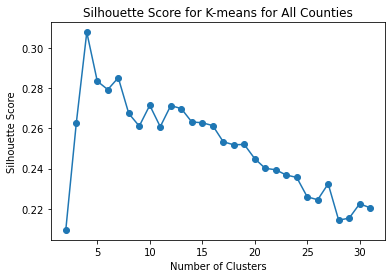

In [164]:
plt.plot(range(2, 51)[:30], silhouette_list[:30], marker = 'o')
plt.ylabel('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.title('Silhouette Score for K-means for All Counties');

In [129]:
kmeans_small = KMeans(n_clusters = 4, random_state = 10)
kmeans_small

KMeans(n_clusters=4, random_state=10)

In [131]:
kmeans_small.fit(X_scaled)

KMeans(n_clusters=4, random_state=10)

In [132]:
labels_small = kmeans_small.labels_

In [157]:
print(f'The silhouette score for KMEANS with four clusters is : {round(silhouette_score(X_scaled, kmeans_small.labels_),3)}.')

The silhouette score for KMEANS with four clusters is : 0.308.


In [133]:
X['labels_small'] = labels_small

<ipython-input-133-5b5e44f1cee7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['labels_small'] = labels_small


In [140]:
X

,percent_below_poverty,smoking_ban_2010,unemployment_rate_2019,obesity_prev_100K,rural_urban_continuum_code_2013,labels_small
fips,,,,,,
01001,15.2,none,3.5,71.952925,2.0,2
01003,10.4,none,4.0,58.781387,3.0,2
01005,30.7,partial,9.4,63.554734,6.0,0
01007,18.1,none,7.0,79.901207,1.0,0
01009,13.6,none,3.1,65.344687,1.0,2
...,...,...,...,...,...,...
56037,11.5,none,5.7,57.186138,5.0,2
56039,6.1,partial,0.7,41.840714,7.0,3
56041,11.3,none,5.5,53.049534,7.0,2


In [159]:
X

,percent_below_poverty,smoking_ban_2010,unemployment_rate_2019,obesity_prev_100K,rural_urban_continuum_code_2013,labels_small
fips,,,,,,
01001,15.2,none,3.5,71.952925,2.0,2
01003,10.4,none,4.0,58.781387,3.0,2
01005,30.7,partial,9.4,63.554734,6.0,0
01007,18.1,none,7.0,79.901207,1.0,0
01009,13.6,none,3.1,65.344687,1.0,2
...,...,...,...,...,...,...
56037,11.5,none,5.7,57.186138,5.0,2
56039,6.1,partial,0.7,41.840714,7.0,3
56041,11.3,none,5.5,53.049534,7.0,2


In [160]:
X.reset_index(inplace = True)

In [162]:
X.to_csv(
    '../data/cleaned/kmeans_clusters_with_labels_and_features.csv',
    index = False
)

In [163]:
test_df = pd.read_csv(
    '../data/cleaned/kmeans_clusters_with_labels_and_features.csv',
    dtype = {'fips':object}
)
test_df

,fips,percent_below_poverty,smoking_ban_2010,unemployment_rate_2019,obesity_prev_100K,rural_urban_continuum_code_2013,labels_small
0,01001,15.2,none,3.5,71.952925,2.0,2
1,01003,10.4,none,4.0,58.781387,3.0,2
2,01005,30.7,partial,9.4,63.554734,6.0,0
3,01007,18.1,none,7.0,79.901207,1.0,0
4,01009,13.6,none,3.1,65.344687,1.0,2
...,...,...,...,...,...,...,...
3127,56037,11.5,none,5.7,57.186138,5.0,2
3128,56039,6.1,partial,0.7,41.840714,7.0,3
3129,56041,11.3,none,5.5,53.049534,7.0,2
3130,56043,10.5,none,4.1,51.512858,7.0,2
